In [1]:
!pip install -q nltk scikit-learn matplotlib seaborn xgboost

# Download NLTK data
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from nltk.corpus import twitter_samples
import pandas as pd

pos = twitter_samples.strings('positive_tweets.json')
neg = twitter_samples.strings('negative_tweets.json')
# For neutral, we split half of positive+negative as neutral (synthetic)
neu = twitter_samples.strings('tweets.20150430-223406.json')[:len(pos)]

df = pd.DataFrame({
    'text': pos + neg + neu,
    'label': [1]*len(pos) + [0]*len(neg) + [2]*len(neu)   # 1=Positive, 0=Negative, 2=Neutral
})

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Class counts:\n", df['label'].value_counts())
df.head()


Class counts:
 label
2    5000
0    5000
1    5000
Name: count, dtype: int64


,text,label
0,RT @abstex: The FT is backing the Tories. On a...,2
1,@cloverness :( I hope something holds your int...,0
2,RT @NicolaSturgeon: If Miliband is going to le...,2
3,Where Was Tony Stark? :) - From Incredible Ton...,1
4,@sainsburys guys a really unlucky one. The dri...,0


In [3]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # remove URLs
    text = re.sub(r'@\w+', '', text)      # remove mentions
    text = re.sub(r'#', '', text)         # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # keep only letters
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()


,text,label,clean_text
0,RT @abstex: The FT is backing the Tories. On a...,2,rt ft backing tories unrelated note heres phot...
1,@cloverness :( I hope something holds your int...,0,hope something holds interest soon
2,RT @NicolaSturgeon: If Miliband is going to le...,2,rt miliband going let tories rather work snp d...
3,Where Was Tony Stark? :) - From Incredible Ton...,1,tony stark incredible tony pictures
4,@sainsburys guys a really unlucky one. The dri...,0,guys really unlucky one driver briefly checked...


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfv = TfidfVectorizer(max_features=40000, ngram_range=(1,2))
X_train_tfv = tfv.fit_transform(X_train)
X_test_tfv = tfv.transform(X_test)

print("Train shape:", X_train_tfv.shape, "Test shape:", X_test_tfv.shape)


Train shape: (12000, 40000) Test shape: (3000, 40000)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_model = LogisticRegression(max_iter=300, class_weight='balanced', multi_class='multinomial')
lr_model.fit(X_train_tfv, y_train)

y_pred_lr = lr_model.predict(X_test_tfv)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=['Negative','Positive','Neutral']))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.8356666666666667
              precision    recall  f1-score   support

    Negative       0.74      0.81      0.77      1000
    Positive       0.78      0.72      0.75      1000
     Neutral       0.99      0.97      0.98      1000

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [10]:
from xgboost import XGBClassifier
import numpy as np

# compute scale_pos_weight for each class
classes = np.unique(y_train)
weights = {cls: len(y_train) / (len(classes) * sum(y_train==cls)) for cls in classes}

sample_weights = [weights[cls] for cls in y_train]

xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    max_depth=6,
    n_estimators=400,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,

)
xgb_model = XGBClassifier(eval_metric='mlogloss')

xgb_model.fit(X_train_tfv, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb_model.predict(X_test_tfv)

print("XGB Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Negative','Positive','Neutral']))


XGB Test Accuracy: 0.8063333333333333
              precision    recall  f1-score   support

    Negative       0.67      0.85      0.75      1000
    Positive       0.79      0.59      0.68      1000
     Neutral       0.99      0.97      0.98      1000

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.80      3000
weighted avg       0.82      0.81      0.80      3000



In [11]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('lr', lr_model), ('xgb', xgb_model)],
    voting='soft'
)

ensemble.fit(X_train_tfv, y_train)
y_pred_ens = ensemble.predict(X_test_tfv)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ens))
print(classification_report(y_test, y_pred_ens, target_names=['Negative','Positive','Neutral']))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Ensemble Accuracy: 0.8306666666666667
              precision    recall  f1-score   support

    Negative       0.73      0.81      0.77      1000
    Positive       0.78      0.70      0.74      1000
     Neutral       0.99      0.98      0.98      1000

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



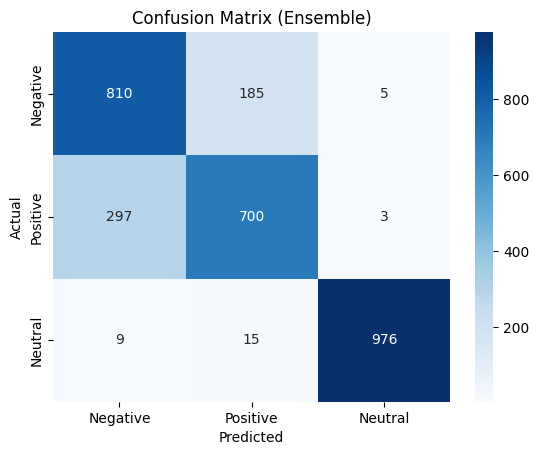

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_ens)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive','Neutral'],
            yticklabels=['Negative','Positive','Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Ensemble)')
plt.show()


In [9]:
def predict_sentence(s):
    clean = clean_text(s)
    vec = tfv.transform([clean])
    pred = ensemble.predict(vec)[0]
    prob = max(ensemble.predict_proba(vec)[0])
    label_map = {0:"Negative",1:"Positive",2:"Neutral"}
    return label_map[pred], prob

samples = [
    "I love this product! Totally recommend it.",
    "This is the worst experience I've ever had.",
    "Not sure how I feel about this"
]

for s in samples:
    label, p = predict_sentence(s)
    print(f"'{s}'  --> {label} (confidence {p:.2f})")


'I love this product! Totally recommend it.'  --> Positive (confidence 0.59)
'This is the worst experience I've ever had.'  --> Negative (confidence 0.65)
'Not sure how I feel about this'  --> Negative (confidence 0.59)
